<a href="https://colab.research.google.com/github/RichardXiao13/Google_Code_In/blob/master/Class_Activation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Activation Heat Maps**

Activation heat maps are great tools for visualizing how a Convolutional Neural Network (CNN) works. During the prediction process of a CNN, it may be very hard to tell what the network is actually looking at to make its predictions. Using a class activation map helps us see where a neural net is looking in an image to classify it. These regions "activate" the network to indicate certain properties that led to the specific classification. Therefore, regions of less importance are not activated. By showing us what properties are activated, activation maps make it much easier to see problems in your neural net when classifying.

# **Imports**
To begin this tutorial, we must first import the following modules. We will be using the VGG16 network to demonstrate activation maps but any other network may work. 

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions

# **Load Image**
Here, we load an image and store in img by using the load_img function from the keras.preprocessing.image module. We set the image resolution to 224, change the image into a numpy array, and expand the dimensions of the image because VGG16 requires batches for the input layer.

In [0]:
IMG_RES = 224
def load_img(img_path):
  img = image.load_img(img_path, target_size=(IMG_RES, IMG_RES))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)
  return img

# **VGG16 Model**
In this cell, we load the VGG16 model from the keras.applications.vgg16 module and inspect a summary of the module.

In [0]:
model = VGG16(weights="imagenet")
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
553467904/553467096 [==============================] - 12s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112

# **Predict**
We then take the image and input it into the model to make a prediction. We can store the label that the model predicted and view it later. The index of the maximum prediction is used to find the loss of the output.

In [0]:
def predict_image(img):
  predictions = model.predict(img)
  label = decode_predictions(predictions, top=1)
  predictions = np.argmax(predictions[0])
  output = model.output[:, predictions]
  return label, output

# **Gradients**
We can use the summary of the model before the get the last convolutional layer in the model. We can then find the gradients of the layer by calling the gradients method from the keras.backend module. These gradients can be used the find the average intensity of each feature map. These averages get stored as tensors in the pooled_gradients variable.

In [0]:
def avg_gradients(output):
  last_conv_layer = model.get_layer('block5_conv3')
  gradients = K.gradients(output, last_conv_layer.output)[0]
  pooled_gradients = K.mean(gradients, axis=(0, 1, 2))
  return pooled_gradients, last_conv_layer

# **Outputs**
To get the values we stored above, we can create a function using keras.backend which takes the input layer of our model and the averaged gradients with the output tensor of the last convolutional layer.

In [0]:
def output_vals(pooled_gradients, last_conv_layer):
  get_output = K.function([model.input], [pooled_gradients, last_conv_layer.output[0]])
  gradient_values, conv_values = get_output([img])
  return gradient_values, conv_values

# **Importance**
Here, we multiply each feature map (of which there are 512) from our outputs of the convolutional layer above by its corresponding gradient value. The gradient value tells us the importance of the feature map when classifying our image.

In [0]:
def activation_func(conv_values, gradient_values):
  for i in range(512):
      conv_values[:, :, i] *= gradient_values[i]
  return conv_values

# **Plot Activation**
This cell creates a heatmap by taking the average values of the 512 feature maps for each index of the 14 by 14 map.

In [0]:
def plot_heatmap(conv_values):
  heatmap = np.mean(conv_values, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  plt.matshow(heatmap)
  plt.show()
  return heatmap

# **Load Image with CV2**
We load the image with the cv2 module and we can resize the heatmap according to the size of the original image. We also convert the heatmap to RGB so we can apply it to the original image. Afterwards, we apply an opacity to the heatmap so that we can see it over the original image. Then, we save the heatmap to a path and we load it to plot. The plot shows which areas on the original image activated the model.

In [0]:
def overlay_map(img_path, heatmap):
  img = cv2.imread(img_path)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  activation = heatmap * 0.7 + img
  save_path = "/content/activation_{}.jpg".format(label[0][0][1])
  cv2.imwrite(save_path, activation)
  img = mpimg.imread(save_path)
  plt.imshow(img)
  plt.title("Predicted " + label[0][0][1])
  plt.axis("off")

# **More Images**
Below, we plot more images along with their activation maps by calling the corresponding functions.

40960/35363 [==================================] - 0s 0us/step


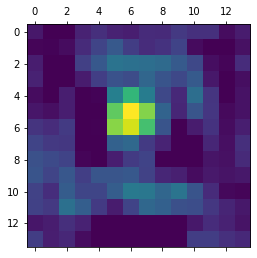

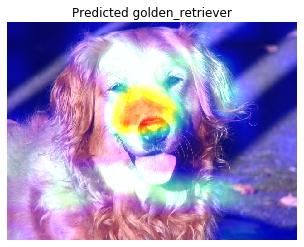

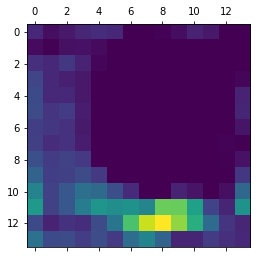

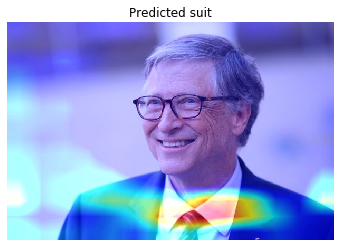

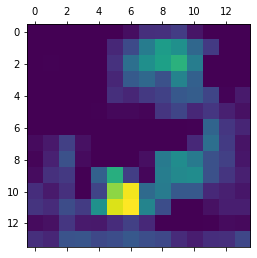

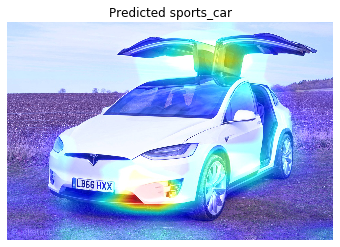

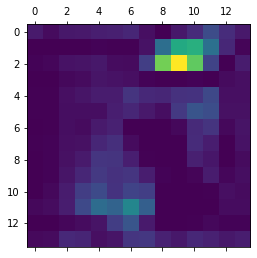

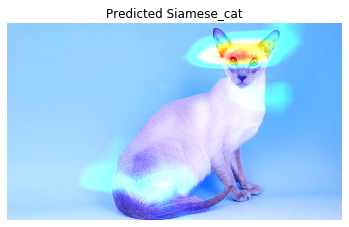

In [0]:
img_paths = ["/content/golden_retriever.jpg", "/content/bill_gates.jpg", "/content/car.jpg", "/content/siamese_cat.jpg"]
for path in img_paths:
  img = load_img(path)
  label, output = predict_image(img)
  pooled_gradients, last_conv_layer = avg_gradients(output)
  gradient_values, conv_values = output_vals(pooled_gradients, last_conv_layer)
  conv_values = activation_func(conv_values, gradient_values)
  heatmap = plot_heatmap(conv_values)
  overlay_map(path, heatmap)

# **Bill Gates**
It may seem that it is strange that the model predicted Bill Gates as a suit, but this is not the  case. The model we have chosen for this tutorial has 1000 classes but not one of those classes correspond to 'human' or 'person', so the model doesn't look for regions that have human features. For this reason, the model looks for regions that correspond to other classes and suit is the most prominent and clearly identifies it with the heatmap.